# HUSKY VERISI ILE EĞITIM YAPILMASI

# Pretrain deep learning

In [2]:
!nvidia-smi

Sun Jan  1 12:32:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 527.56       Driver Version: 527.56       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   41C    P8    30W / 240W |    673MiB /  8192MiB |      9%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Kutulanmış Lidar Verisinin Okunması

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def readBinDataset(filename):
    binDataset = np.load(filename, allow_pickle=True)
    #print(bin)

    return binDataset

# Tüm veri setinin okunması aşağıdadır

In [3]:
total_dataset_sz = 11 # bu dizi olarak ayarlanacak
distributed_time = 5
binDataset_ = []

In [4]:
#windows
for sequence in range(total_dataset_sz):
    binDataset_.append(readBinDataset(r"D:\Ara\numpy_dataset_sequences\%02d_angleBin.npy" % sequence))
    binDataset_[sequence]=binDataset_[sequence].reshape((len(binDataset_[sequence]), 3601,1 ))
    binDataset_[sequence] = np.array([ consec_frames for consec_frames in zip(binDataset_[sequence][0::], binDataset_[sequence][1::])])

# linux
#binDataset=readBinDataset("/mnt/d/Ara/numpy_dataset_sequences/%02d_angleBin.npy" % sequence)

In [5]:
len(binDataset_),  binDataset_[0].shape

(11, (4540, 2, 3601, 1))

In [6]:
from IPython.display import clear_output
import pykitti
from scipy.spatial.transform import Rotation as R

%matplotlib inline
label_ = []
for sequence in range(total_dataset_sz):
    
    basedir = 'D:\\dataset\\'
    sequence_ = '%02d' % sequence
    dataset = pykitti.odometry(basedir, sequence_)
    
   
    x=np.array([])
    y=np.array([])
    z=np.array([])
    yaw=np.array([])

    fig = plt.figure(sequence)
    ax = fig.add_subplot(projection='3d' )
    ax.set_title(str(sequence))
    for i in range(len(dataset.poses)):
        x=np.append(x, [dataset.poses[i][0][3]])
        y=np.append(y, [dataset.poses[i][1][3]])
        z=np.append(z, [dataset.poses[i][2][3]])

    ax.scatter(x, y, z, marker='o')
    
    ax.view_init(-140, 60)
    plt.pause(0.1)
    plt.clf()

    t_xyz = np.c_[x, y, z]
    dt_xyz = t_xyz[1:] - t_xyz[0:-1]
    dt_xz = dt_xyz[:,[0,2]]
    translation_ = np.sqrt( dt_xz[:,0]** 2 +  dt_xz[:,1]**2)

    translation_ += 0.28 
    
    
    fig1 = plt.figure()
    yaw_=np.zeros(len(dataset.poses))
    for i in range(len(dataset.poses)):
        r= R.from_matrix([[dataset.poses[i][0][0], dataset.poses[i][0][1], dataset.poses[i][0][2]], [dataset.poses[i][1][0], dataset.poses[i][1][1], dataset.poses[i][1][2]], [dataset.poses[i][2][0], dataset.poses[i][2][1], dataset.poses[i][2][2]]])
        yaw=-r.as_rotvec()[1]
        yaw_[i]=yaw
    # plt.plot(np.rad2deg(yaw_))

    diff_pitch_ = -(yaw_[1::]-yaw_[:-1:])

    # outlier detection
    idxs = np.where((diff_pitch_>np.deg2rad(300)) | (diff_pitch_<np.deg2rad(-300)))

    diff_pitch_[idxs] =  diff_pitch_[idxs] - np.deg2rad(360)  * np.sign(diff_pitch_[idxs])

    label_.append(np.transpose(np.array((translation_,diff_pitch_))))
    
    plt.plot((np.rad2deg(diff_pitch_)))
    plt.pause(0.001)
    plt.clf()
#     plt.ylim([-4, 4])
#     plt.show()

clear_output(wait=True)

<Figure size 640x480 with 0 Axes>

In [7]:
((len(label_)), binDataset_[0].shape, label_[0].shape)

(11, (4540, 2, 3601, 1), (4540, 2))

In [8]:
binDataset_ = np.array(binDataset_)
label_ = np.array(label_)

C:\Users\filiz\AppData\Local\Temp\ipykernel_1296\4136154583.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  binDataset_ = np.array(binDataset_)
C:\Users\filiz\AppData\Local\Temp\ipykernel_1296\4136154583.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  label_ = np.array(label_)


In [9]:
binDataset_.shape, label_.shape

((11,), (11,))

In [10]:
binDataset_[0].shape, label_[0].shape

((4540, 2, 3601, 1), (4540, 2))

In [11]:
for i in range(len(binDataset_)) :
    binDataset_[i] = binDataset_[i][:binDataset_[i].shape[0]-binDataset_[i].shape[0]%distributed_time]
    label_[i] = label_[i][:label_[i].shape[0]-label_[i].shape[0]%distributed_time]

In [12]:
binDataset_[1].shape, label_[1].shape

((1100, 2, 3601, 1), (1100, 2))

In [13]:
binDataset = np.concatenate(binDataset_)
label = np.concatenate(label_)

In [14]:
binDataset.shape, label.shape

((23190, 2, 3601, 1), (23190, 2))

# Tek sequence veri okuması aşağıdadır

In [15]:
# sequence = 0
# time_distributed = 100 

In [16]:
# #windows
# binDataset=readBinDataset(r"D:\Ara\numpy_dataset_sequences\%02d_angleBin.npy" % sequence)

# # linux
# #binDataset=readBinDataset("/mnt/d/Ara/numpy_dataset_sequences/%02d_angleBin.npy" % sequence)

In [ ]:
# binDataset.shape

In [ ]:
# binDataset=binDataset.reshape((len(binDataset), 3601,1 ))

In [ ]:
# binDataset = np.array([ consec_frames for consec_frames in zip(binDataset[0::], binDataset[1::])])

In [ ]:
# binDataset[0][0], binDataset[0][1]

In [ ]:
# binDataset.shape

In [ ]:
# plt.rcParams["figure.figsize"] = (15,5.5)

In [23]:
# binDataset[0].shape

In [24]:
# # windows
# posePath = "D:\\Ara\\poses\\"
# # linux
# # posePath = "/mnt/d/Ara/poses/"
# poseIdx = "%02d" % sequence
# pose = poseIdx + ".txt"

In [166]:
# filePath = posePath+pose
# file = open(filePath,'r')

In [167]:
# def isRotationMatrix(R):
#     Rt = np.transpose(R)
#     shouldBeIdentity = np.dot(Rt, R)
#     I = np.identity(3, dtype=R.dtype)
#     n = np.linalg.norm(I - shouldBeIdentity)
#     return n < 1e-6

In [168]:
# import math
# # from scipy.spatial.transform import Rotation as R

# def rotationMatrixToEulerAngles(R):
#     assert (isRotationMatrix(R))
#     sy = math.sqrt(R[0, 0] * R[0, 0] + R[1, 0] * R[1, 0])
#     singular = sy < 1e-6

#     if not singular:
#         x = math.atan2(R[2, 1], R[2, 2])
#         y = math.atan2(-R[2, 0], sy)
#         z = math.atan2(R[1, 0], R[0, 0])
#     else:
#         x = math.atan2(-R[1, 2], R[1, 1])
#         y = math.atan2(-R[2, 0], sy)
#         z = 0

#     return np.array([x, y, z])
#     r = R.from_matrix(RMat)
#     return r.as_euler('xyz')


In [169]:
# def get6DoFPose(line):
#     rotationTranslation = line.split()
#     #print(rotationTranslation)
    
    
#     homogenousCoord = np.array(rotationTranslation, dtype=np.float64).reshape((3,4))
#     homogenousCoord = np.append(homogenousCoord, [[0,0,0,1]], axis=0)

#     #print(homogenousCoord)
#     R = homogenousCoord[0:3,0:3]
#     pos = homogenousCoord[0:3,3]
#     #print(R , pos)
    
#     # assert(1==3)

    
#     angles = rotationMatrixToEulerAngles(R)

#     return np.concatenate((pos, angles)), homogenousCoord

In [170]:
# import pykitti
# import numpy as np
# import math 
# import matplotlib.pyplot as plt
# from scipy.spatial.transform import Rotation as R

In [171]:
# %matplotlib inline
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')

# x=np.array([])
# y=np.array([])
# z=np.array([])
# yaw=np.array([])

# basedir = 'D:\\dataset\\'
# sequence_ = '%02d' % sequence
# dataset = pykitti.odometry(basedir, sequence_)
# for i in range(len(dataset.poses)):
#     x=np.append(x,[dataset.poses[i][0][3]])
#     y=np.append(y,[dataset.poses[i][1][3]])
#     z=np.append(z,[dataset.poses[i][2][3]])

# ax.scatter(x, y, z, marker='o')

# t_xyz = np.c_[x,y,z]
# ax.view_init(-140, 60)

# plt.show()

In [172]:
# dt_xyz = t_xyz[1:] - t_xyz[0:-1]
# plt.plot(dt_xyz)

In [173]:
# dt_xz = dt_xyz[:,[0,2]]

In [174]:
# translation = np.sqrt( dt_xz[:,0]** 2 +  dt_xz[:,1]**2)
# plt.xticks(range(0, len(translation),int(len(translation)/20)))
# plt.plot(translation)
# np.mean(translation)

In [175]:
# fig1 = plt.figure()
# # arrow = plt.axes()
# yaw_=np.zeros(len(dataset.poses))
# for i in range(len(dataset.poses)):
#     r= R.from_matrix([[dataset.poses[i][0][0], dataset.poses[i][0][1], dataset.poses[i][0][2]], [dataset.poses[i][1][0], dataset.poses[i][1][1], dataset.poses[i][1][2]], [dataset.poses[i][2][0], dataset.poses[i][2][1], dataset.poses[i][2][2]]])
#     yaw=-r.as_rotvec()[1]
#     yaw_[i]=yaw
#     # arrow.arrow(x[i], y[i], math.sin(yaw), math.cos(yaw), head_width=0.05, head_length=0.1, fc='k', ec='k')
# # plt.plot(np.rad2deg(yaw_))

# diff_pitch = (yaw_[1::]-yaw_[:-1:])

# # outlier detection
# idxs = np.where((diff_pitch>np.deg2rad(300)) | (diff_pitch<np.deg2rad(-300)))

# diff_pitch[idxs] =  diff_pitch[idxs] - np.deg2rad(360)  * np.sign(diff_pitch[idxs])

# diff_pitch = -diff_pitch
# plt.plot((np.rad2deg(diff_pitch)))
# plt.ylim([-4, 4])
# plt.show()

In [176]:
# len(t_xyz) , len(yaw)

# label = np.array((translation,diff_pitch))
# label = label.transpose()
# binDataset.shape, label.shape

# Output Çıktısının(translation, rotation) Kutulanması(Örneklenmesi) İşlemi  

In [15]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(label)

label = scaler.transform(label)
scaler.data_max_, scaler.data_min_

(array([3.01743329, 0.07704157]), array([ 0.28007151, -0.08327863]))

In [16]:
def binOutput(label, sample_sz):
    t_bin = np.zeros(sample_sz)
    r_bin = np.zeros(sample_sz)

    interval = sample_sz-1

    t_bin = np.zeros(sample_sz)
    r_bin = np.zeros(sample_sz)
    labelBinned = np.array([[t_bin,r_bin]])
    for data in label:
        t_bin = np.zeros(sample_sz)
        r_bin = np.zeros(sample_sz)
        t_bin[int(((data[0]*interval)))] = 1
        r_bin[int(((data[1]*interval)))] = 1
        
        labelBinned = np.concatenate([labelBinned, np.array([np.array([t_bin, r_bin])])], axis=0)
    return labelBinned[1:]

In [17]:
labelBinned = binOutput(label, 21)

In [18]:
labelBinned.shape, label.shape

((23190, 2, 21), (23190, 2))

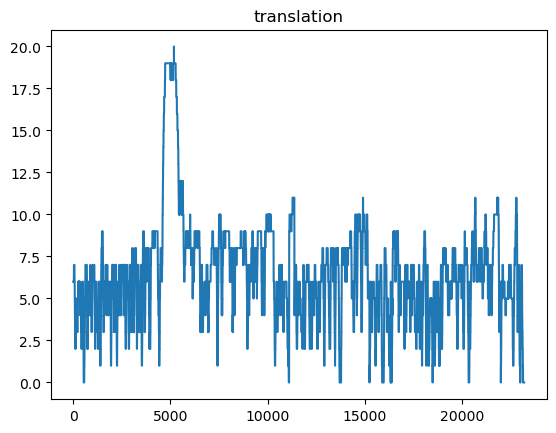

In [19]:
np.where(labelBinned[:,0] > 0)[1]
plt.title('translation')
plt.plot(np.where(labelBinned[:,0] > 0)[1])

Burada outlier veriler bulunmakta bunlar histogram olarak incelenir.

(array([ 872., 2497., 4903., 7689., 5161., 1214.,   80.,   73.,  117.,
         584.]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.]),
 <BarContainer object of 10 artists>)

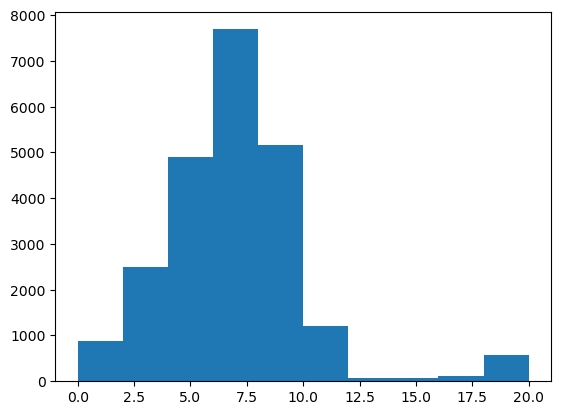

In [20]:
plt.hist(np.where(labelBinned[:,0] > 0)[1])

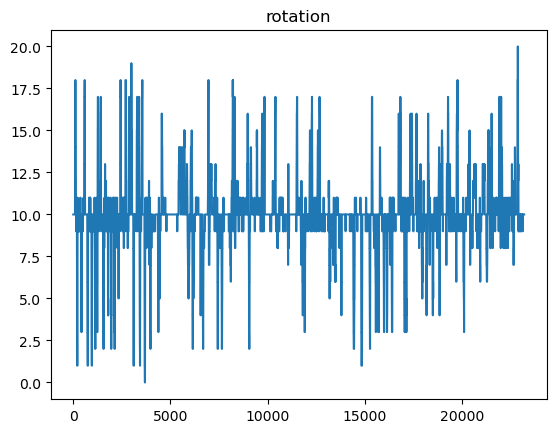

In [21]:
np.where(labelBinned[:,1] > 0)[1].shape
plt.title('rotation')
plt.plot(np.where(labelBinned[:,1] > 0)[1])

(array([   63.,   349.,   553.,   811.,  3400., 15197.,  1483.,   758.,
          484.,    92.]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.]),
 <BarContainer object of 10 artists>)

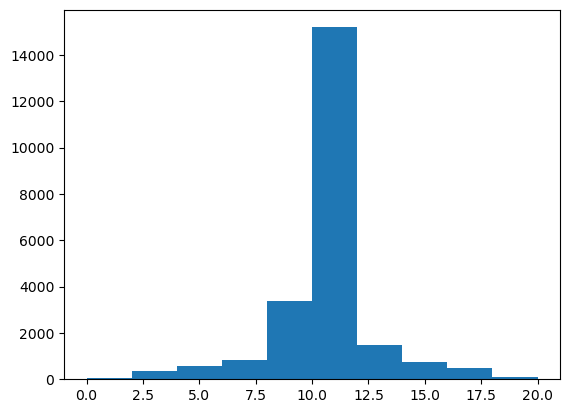

In [22]:
plt.hist(np.where(labelBinned[:,1] > 0)[1])

## Translation dan gelen outlier ların silinmesi

In [23]:
outliers = np.where(np.where(labelBinned[:,0] > 0)[1]>11)
outliers = outliers[0]

In [24]:
(outliers[-1] - outliers[0]) == (max(outliers) - min(outliers))

True

In [25]:
min_truncate = outliers[0] - outliers[0] % distributed_time
max_truncate = outliers[-1] - outliers[-1] % distributed_time
min_truncate, max_truncate

(4605, 5635)

In [26]:
labelBinned=np.delete(labelBinned,np.s_[min_truncate:max_truncate],axis=0 )
binDataset=np.delete(binDataset,np.s_[min_truncate:max_truncate],axis=0 )

## After Translation Outlier Analysis

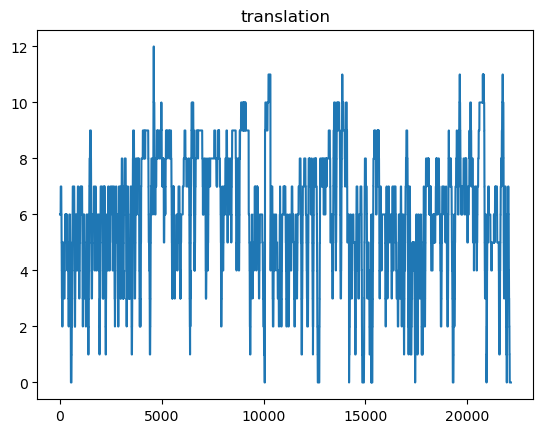

In [27]:
np.where(labelBinned[:,0] > 0)[1]
plt.title('translation')
plt.plot(np.where(labelBinned[:,0] > 0)[1])

(array([ 872.,  959., 1538., 2072., 2831., 7689., 2881., 2280.,  890.,
         148.]),
 array([ 0. ,  1.2,  2.4,  3.6,  4.8,  6. ,  7.2,  8.4,  9.6, 10.8, 12. ]),
 <BarContainer object of 10 artists>)

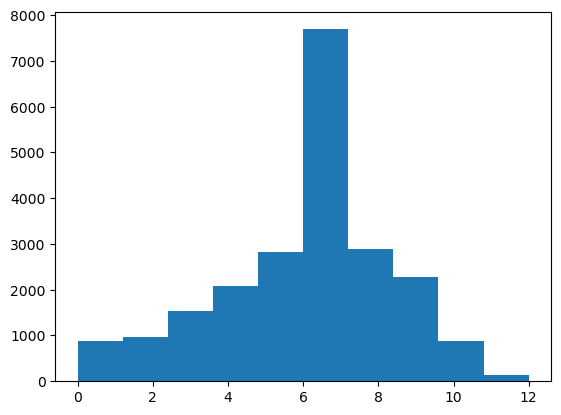

In [28]:
plt.hist(np.where(labelBinned[:,0] > 0)[1])

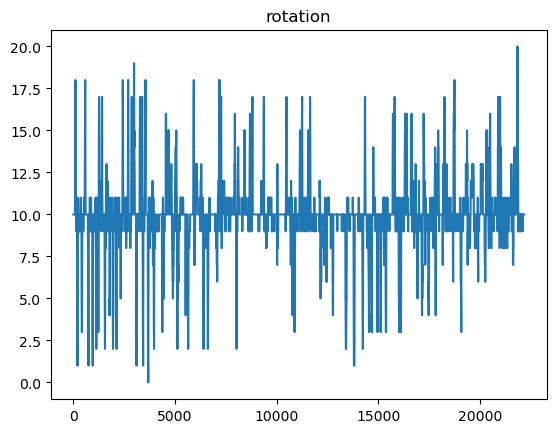

In [29]:
np.where(labelBinned[:,1] > 0)[1].shape
plt.title('rotation')
plt.plot(np.where(labelBinned[:,1] > 0)[1])

(array([   63.,   349.,   553.,   811.,  3395., 14339.,  1384.,   690.,
          484.,    92.]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.]),
 <BarContainer object of 10 artists>)

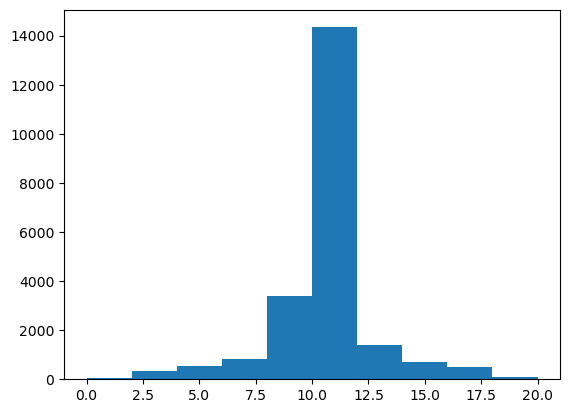

In [30]:
plt.hist(np.where(labelBinned[:,1] > 0)[1])

# Eğitim için gerekli kütüphanelerin getirilmesi ve verilerin tensor matrisi olarak oluşturulması

In [31]:
import tensorflow as tf

In [32]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import concatenate
from keras.layers import TimeDistributed
from keras.layers import LSTM, GRU

In [33]:
np.random.seed(16)
tf.random.set_seed(16)

In [34]:
binDataset[:len(binDataset)].shape, label[:len(binDataset)].shape

((22160, 2, 3601, 1), (22160, 2))

In [35]:
binDataset = binDataset[:len(binDataset)]
label = label[:len(binDataset)]
labelBinned = labelBinned[:len(binDataset)]

In [36]:
binDataset=binDataset.reshape((int(len(binDataset)/distributed_time),distributed_time,2,3601,1))
labelBinned = labelBinned.reshape((int(len(labelBinned)/distributed_time),distributed_time,2,21))
# label = label.reshape((110,10,2))

In [37]:
int(len(binDataset))

4432

In [38]:
binDataset.shape, labelBinned.shape

((4432, 5, 2, 3601, 1), (4432, 5, 2, 21))

In [39]:
translation = labelBinned[:,:,0,:]
rotation = labelBinned[:,:,1,:]

In [40]:
translation.shape, rotation.shape

((4432, 5, 21), (4432, 5, 21))

In [41]:
# with tf.device('/device:GPU:0'):
dataset = tf.data.Dataset.from_tensor_slices((binDataset, {"translation": translation, "rotation" : rotation} ))
# tf.compat.v1.disable_eager_execution()
# data = (binDataset,label)
# a = tf.compat.v1.placeholder(tf.float32,shape=binDataset.shape)
# dataset = tf.data.Dataset.from_tensor_slices(a)
# dataset = dataset.prefetch(buffer_size=1000)
# dataset = dataset.batch(128)
# iterator = tf.compat.v1.data.make_initializable_iterator(dataset)
# next_batch = iterator.get_next()
# with tf.compat.v1.Session() as sess:
#     sess.run(iterator.initializer, feed_dict={a: binDataset})

In [42]:
DATASET_SIZE = len(dataset)
DATASET_SIZE

4432

In [43]:
train_size = int(0.90 * DATASET_SIZE)
val_size = int(0.05 * DATASET_SIZE)
test_size = int(0.05 * DATASET_SIZE)
#.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
full_dataset = dataset.shuffle(buffer_size=100).prefetch(buffer_size=tf.data.AUTOTUNE)

train_data = full_dataset.take(train_size).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = full_dataset.skip(train_size).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = test_data.skip(test_size).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.take(test_size).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [44]:
# train_data, val_data, test_data

In [45]:
# train_one_sample=train_data.take(1)
# train_one_sample

In [46]:
# for datum, label in train_one_sample:
#   print(f"""
#   bin shape: {datum.shape}
#   bin dtype: {datum.dtype}
#   bin data : {datum}
#   translation : {np.where(label['translation'] > 0)[1]}
#   rotation : {np.where(label['rotation'] > 0)[1]}
#         """)

# Temel CNN Ağının Üretilmesi

Bu ağ üzerinde önceden eğitim yapılıp ağırlıklandırılmış olacak sonrasında zamana göre dağıtılmış veriler ile eğitilecek

In [47]:
# Create a CNN model (same as Tiny VGG - https://poloclub.github.io/cnn-explainer/)
model = Sequential([
  Conv1D(filters=32, 
          kernel_size=3, # can also be (3, 3)
          strides=1,
          activation="relu",
          padding="same",
          input_shape=(2, 3601, 1), name="Conv1"), # first layer specifies input shape (height, width, colour channels)
  Conv1D(32, 3, 2,  padding="same",activation="relu", name="Conv2"),
    
  AveragePooling2D(pool_size=(1,3),
                                     strides=(1,3),data_format='channels_last', padding='valid', name="AvgPool"),
  Conv1D(64, 3, 1,  padding="same",activation="relu", name="Conv3"),
  Conv1D(64, 3, 2,  padding="same",activation="relu", name="Conv4"),
  
  AveragePooling2D(pool_size=(1,3),
                                     strides=(1,3),data_format='channels_last', padding='valid', name="AvgPool2"),
  
  Conv1D(128, 3, 1,  padding="same",activation="relu", name="Conv5"),
  Conv1D(128, 3, 2,  padding="same",activation="relu", name="Conv6"),

  AveragePooling2D(pool_size=(1,3),strides=(1,3),data_format='channels_last', padding='valid', name="AvgPool3"),
  
  Conv1D(256, 3, 1,  padding="same",activation="relu", name="Conv7"),
  Conv1D(256, 3, 2,  padding="same",activation="relu", name="Conv8"),

  AveragePooling2D(pool_size=(1,3),strides=(1,3),data_format='channels_last', padding='valid', name="AvgPool4"),
  
    Flatten(),
  ])

In [48]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv1D)              (None, 2, 3601, 32)       128       
                                                                 
 Conv2 (Conv1D)              (None, 2, 1801, 32)       3104      
                                                                 
 AvgPool (AveragePooling2D)  (None, 2, 600, 32)        0         
                                                                 
 Conv3 (Conv1D)              (None, 2, 600, 64)        6208      
                                                                 
 Conv4 (Conv1D)              (None, 2, 300, 64)        12352     
                                                                 
 AvgPool2 (AveragePooling2D)  (None, 2, 100, 64)       0         
                                                                 
 Conv5 (Conv1D)              (None, 2, 100, 128)       2

# Temel CNN modelinin yüklenmesi 

In [49]:
# load json and create model
json_file = open('kfold_cnn_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("kfold_cnn_model.h5")
print("Loaded model from disk")

Loaded model from disk


In [50]:
loaded_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2, 3601, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 sequential_1 (Sequential)      (None, 4096)         95776       ['input_1[0][0]',                
                                                                  'input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 512)          2097664     ['sequential_1[0][0]']           
                                                                                              

# Ana CNN Ağının Zamana Göre Arıtılmış Üretilmesi

In [98]:
input_layer = tf.keras.layers.Input(shape=(None,2,3601,1), ragged=True)
cnn_model = model
# for layer in model.layers:
#     layer._inbound_nodes = []
#     cnn_model = layer(cnn_model)

In [99]:
cnn_model = TimeDistributed(cnn_model)(input_layer)

In [100]:
cnn_model = LSTM(1024,return_sequences=True)(cnn_model)

In [101]:
cnn_model = LSTM(1024, return_sequences=True)(cnn_model)

In [102]:
model1 = TimeDistributed(Dense(512, activation='relu'))(cnn_model)
model2 = TimeDistributed(Dense(512, activation='relu'))(cnn_model)

model1 = TimeDistributed(Dropout(0.2) )(model1)
model2 = TimeDistributed(Dropout(0.2) )(model2)


model1 = TimeDistributed(Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-3)))(model1)
model2 = TimeDistributed(Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-3)))(model2)

model1 = TimeDistributed(Dropout(0.2)) (model1)
model2 = TimeDistributed(Dropout(0.2)) (model2)

# model1 = TimeDistributed(Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-3)))(model1)
# model2 = TimeDistributed(Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-3)))(model2)

# model1 = TimeDistributed(Dropout(0.2)) (model1)
# model2 = TimeDistributed(Dropout(0.2)) (model2)

model1 = TimeDistributed(Dense(21,activation='softmax'), name="translation")(model1) # translate
model2 = TimeDistributed(Dense(21,activation='softmax'), name="rotation")(model2) # yaw

# model1 = tf.keras.layers.Activation('softmax', name="translation")(model1)
# model2 = tf.keras.layers.Activation('softmax', name="rotation")(model2)

pre_model = tf.keras.Model(inputs=[input_layer], outputs=[model1, model2])
# losses = {
# 	"translation": CustomAccuracyTranslation(),
# 	"rotation": CustomAccuracyRotation(),
# }
# # losses = {"translation" : "mse", "rotation" : "mse"}
# loss_weights = {'translation' : 1, 'rotation' : 150}
# pre_model.compile(optimizer='adam',  loss=losses,loss_weights=loss_weights, metrics={"translation": ["mse"], "rotation": ["mse"]})
# pre_model.compile(loss = 'binary_crossentropy',
#               optimizer = tf.keras.optimizers.SGD(0.001, momentum=0.9),
#               metrics = ['accuracy'])

In [103]:
pre_model.compile(loss = 'categorical_crossentropy',
              optimizer='adam',
              metrics = ['accuracy'])

In [104]:
pre_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 2, 36  0           []                               
                                01, 1)]                                                           
                                                                                                  
 time_distributed (TimeDistribu  (None, None, 1024)  391200      ['input_1[0][0]']                
 ted)                                                                                             
                                                                                                  
 lstm (LSTM)                    (None, None, 1024)   8392704     ['time_distributed[0][0]']       
                                                                                              

In [105]:
# !conda install graphviz -y
# !conda install pydot -y
# !conda install pydotplus -y

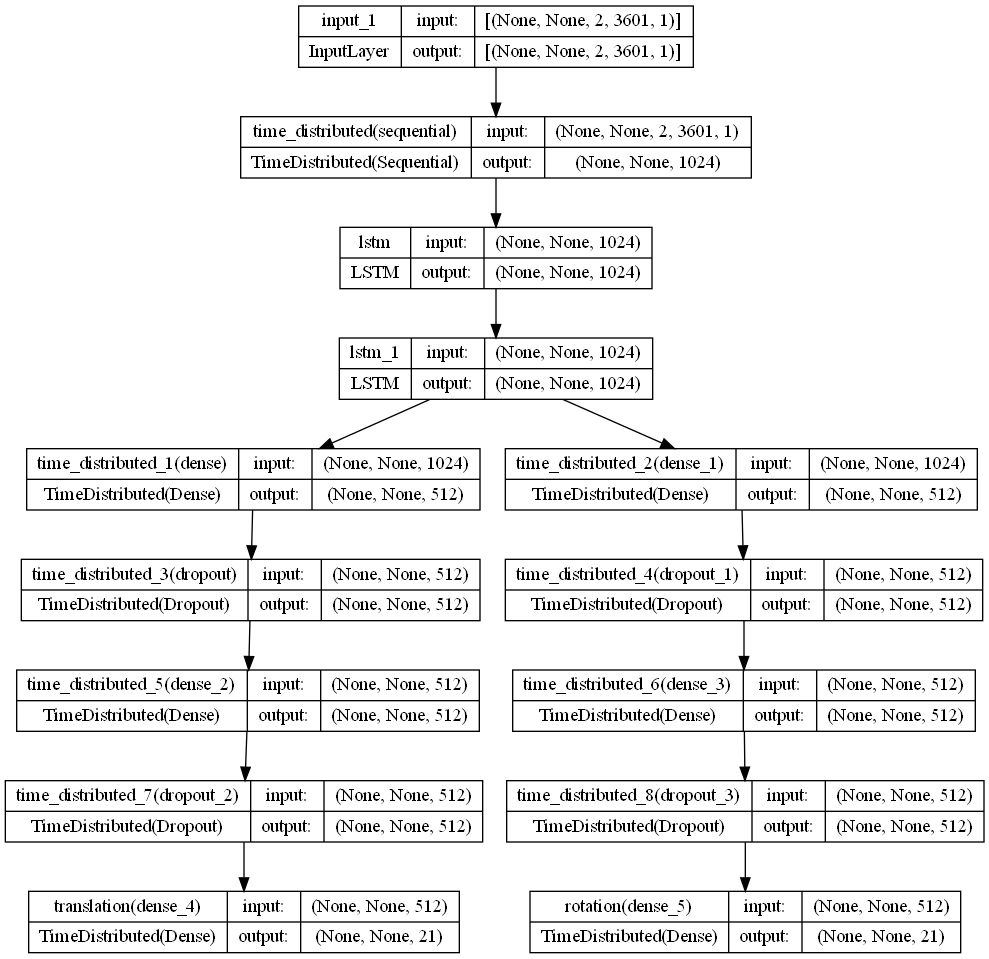

In [106]:
tf.keras.utils.plot_model(pre_model, show_shapes=True)

In [107]:
# train_data, val_data, test_data
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [108]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Önceden Eğitilmiş CNN ağının eklenmesi

In [109]:
seq = loaded_model.layers[1]
# model = seq
pre_model.layers[1].set_weights(loaded_model.layers[1].get_weights())

In [110]:
loaded_model.layers, pre_model.layers

([<keras.engine.input_layer.InputLayer at 0x2710929ad60>,
  <keras.layers.rnn.time_distributed.TimeDistributed at 0x2710d819310>])

In [111]:
# pre_model.layers[-8].set_weights(loaded_model.layers[-8].get_weights())
[pre_model.layers[i].set_weights(loaded_model.layers[i].get_weights()) for i in list(map(lambda x : -x, list(range(1,11))))]

[None, None, None, None, None, None, None, None, None, None]

In [114]:
pre_model.fit(train_data, validation_data=val_data, verbose=1, epochs=10)

Epoch 1/10
125/125 [==============================] - 14s 97ms/step - loss: 0.1117 - translation_loss: 0.0459 - rotation_loss: 0.0521 - translation_accuracy: 0.9876 - rotation_accuracy: 0.9862 - val_loss: 1.5562 - val_translation_loss: 0.7517 - val_rotation_loss: 0.7906 - val_translation_accuracy: 0.8332 - val_rotation_accuracy: 0.8466
Epoch 2/10
125/125 [==============================] - 12s 94ms/step - loss: 0.0907 - translation_loss: 0.0428 - rotation_loss: 0.0336 - translation_accuracy: 0.9883 - rotation_accuracy: 0.9897 - val_loss: 2.0084 - val_translation_loss: 1.2028 - val_rotation_loss: 0.7915 - val_translation_accuracy: 0.7659 - val_rotation_accuracy: 0.8511
Epoch 3/10
125/125 [==============================] - 12s 93ms/step - loss: 0.0978 - translation_loss: 0.0514 - rotation_loss: 0.0325 - translation_accuracy: 0.9854 - rotation_accuracy: 0.9911 - val_loss: 1.8420 - val_translation_loss: 1.1204 - val_rotation_loss: 0.7081 - val_translation_accuracy: 0.7973 - val_rotation_acc

In [115]:
scores = pre_model.evaluate(test_data, verbose=0)
print(f'Score of no fold train of cnn integrated time distributed model: translation accuracy of {scores[-2]}; rotation accuracy of {scores[-1]}')

Score of no fold train of cnn integrated time distributed model: translation accuracy of 0.9167420864105225; rotation accuracy of 0.8995475172996521


In [116]:
scores

[1.0314323902130127,
 0.42317795753479004,
 0.6006353497505188,
 0.9167420864105225,
 0.8995475172996521]

In [68]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5588037019015794824
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5748293632
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9588124116012367552
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

## K fold olarak time distributed verinin eğitilmesi

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

binDataset_train, binDataset_test, label_train_t, label_test_t , label_train_r ,label_test_r = train_test_split(binDataset, labelBinned[:,0,:], labelBinned[:,1,:], test_size=0.33)

In [135]:
from keras import backend as K
import keras

def reset_weights(model):
    for layer in model.layers: 
        if isinstance(layer, tf.keras.Model):
            reset_weights(layer)
            continue
        for k, initializer in layer.__dict__.items():
            if "initializer" not in k:
                continue
            # find the corresponding variable
            var = getattr(layer, k.replace("_initializer", ""))
            var.assign(initializer(var.shape, var.dtype))

In [ ]:
# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True)

verbosity = 1
no_epochs = 30
batch_size = 32

In [113]:
reset_weights(pre_model)
keras.backend.clear_session()

In [87]:
seq = loaded_model.layers[1]
# model = seq
pre_model.layers[1].set_weights(loaded_model.layers[1].get_weights())

In [ ]:

for train, test in kfold.split(binDataset_train, label_train_t):
    train_data_ = binDataset_train[train]
    train_label_t = label_train_t[train]
    train_label_r = label_train_r[train]
    


    dataset_ = tf.data.Dataset.from_tensor_slices((train_data_, {"translation": train_label_t, "rotation" : train_label_r}))
    full_dataset_ = dataset_.shuffle(buffer_size=100).batch(batch_size=batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

    history=pre_model.fit(full_dataset_,
              epochs=no_epochs,
              verbose=verbosity)
    

    test_data_ = binDataset_train[test]
    test_label_t = label_train_t[test]
    test_label_r = label_train_r[test]
    

    test_label_data = {"translation": test_label_t, "rotation" : test_label_r}

    # Generate generalization metrics
    scores = pre_model.evaluate(test_data_, test_label_data, verbose=0)
    print(f'Score for fold {fold_no}: {pre_model.metrics_names[-2]} of {scores[-2]}; {pre_model.metrics_names[-1]} of {scores[-1]}')
    
    fold_no = fold_no + 1

    

# Tek sequence ya da çok sequence açık olan yorum satırına göre eğitimi

In [53]:
pre_model.output

NameError: name 'pre_model' is not defined

In [75]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 5, 2, 3601, 1), dtype=tf.float64, name=None), {'translation': TensorSpec(shape=(None, 5, 21), dtype=tf.float64, name=None), 'rotation': TensorSpec(shape=(None, 5, 21), dtype=tf.float64, name=None)})>

In [81]:
predictions = pre_model.predict(test_data)

7/7 [==============================] - 4s 51ms/step


In [82]:
prediction_train = pre_model.predict(train_data)

125/125 [==============================] - 5s 36ms/step


# Örnek Batch verisi kontrolü

In [83]:
train_batch = train_data.as_numpy_iterator()

In [84]:
example_trained_data = train_batch.next()

In [85]:
example_trained_data[0].shape # input

(32, 5, 2, 3601, 1)

In [86]:
example_trained_data[1]['translation'].shape, example_trained_data[1]['rotation'].shape

((32, 5, 21), (32, 5, 21))

In [99]:
example_bin_input_time_distributed = example_trained_data[0][0]
example_bin_input_time_distributed.shape
example_bin_output_time_distributed_translation = example_trained_data[1]['translation'][0]
example_bin_output_time_distributed_rotation = example_trained_data[1]['rotation'][0]

In [ ]:
def plotAngleBin(ax,angleBin):
    ax.cla()
    ax.scatter(0,0)
    xList = []
    yList = []
    for angle, bin in enumerate(angleBin):
        if bin > 0:
            y=bin*np.sin(np.deg2rad(angle*0.1))
            x=bin*np.cos(np.deg2rad(angle*0.1))
            xList.append(x)
            yList.append(y)
            # ax.scatter(x,y)
    ax.scatter(xList,yList)
    plt.pause(0.00000000000001)
    plt.show()

In [ ]:
%matplotlib qt
# %matplotlib inline
fig, axs = plt.subplots(2)
axs[0].set_aspect('equal', adjustable='box')
axs[1].set_aspect('equal', adjustable='box')

for i in range(len(example_bin_input_time_distributed)):
    fig.suptitle("Zaman Serisinde Verilen iki resim")
    text = fig.text(0.1, 0.1,"translation:{translation} rotation:{rotation} ".format(translation=np.argmax(example_bin_output_time_distributed_translation[i]), rotation=np.argmax(example_bin_output_time_distributed_rotation[i])))
    plotAngleBin(axs[0], example_bin_input_time_distributed[i][0])
    
    plotAngleBin(axs[1], example_bin_input_time_distributed[i][1])
    text.remove()
    # print(example_bin_input_time_distributed[i][0] == example_bin_input_time_distributed[i][1])


# Modelden elde edilen çıktıların doğruluk kontrolü

In [88]:
prediction_train[1].shape

(3988, 5, 21)

In [89]:
len(prediction_train), len(train_data)

(2, 125)

In [90]:
X_train = list(map(lambda x: x[0], train_data))
y_train = list (map(lambda x: x[1], train_data))

In [91]:
X_train[6].shape

TensorShape([32, 5, 2, 3601, 1])

In [92]:
y_train[6]['translation'].shape

TensorShape([32, 5, 21])

In [93]:
prediction_train[0].shape

(3988, 5, 21)

In [94]:
tf.concat([i['translation'] for i in y_train], axis=0)[0].shape

TensorShape([5, 21])

In [95]:
np.argmax(tf.concat([i['translation'] for i in y_train], axis=0)[0], axis=1)

array([3, 3, 3, 3, 3], dtype=int64)

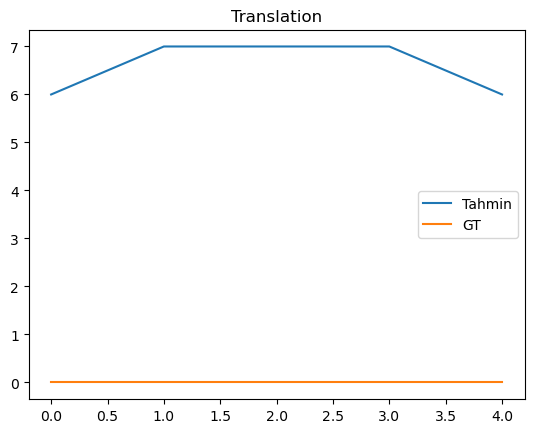

In [96]:
%matplotlib inline
plt.plot(np.argmax(prediction_train[0][30], axis=1),label="Tahmin")
plt.plot(np.argmax(tf.concat([i['translation'] for i in y_train], axis=0)[30], axis=1), label="GT")

plt.title("Translation")
#plt.xlim([0,50])

plt.legend()
plt.show()

In [97]:
prediction_train[0].shape

(3988, 5, 21)

In [98]:
%matplotlib qt
ax = plt.axes()

for i in range(prediction_train[0].shape[0]-1):
    ax.cla()
    ax.plot(np.argmax(prediction_train[0][i], axis=1),label="Tahmin")
    ax.plot(np.argmax(tf.concat([i['translation'] for i in y_train], axis=0)[i], axis=1), label="GT")

    ax.set_title("Translation frame : " + str(i))
    #plt.xlim([0,50])

    ax.legend()
    plt.pause(0.0000000000001)
    plt.show()

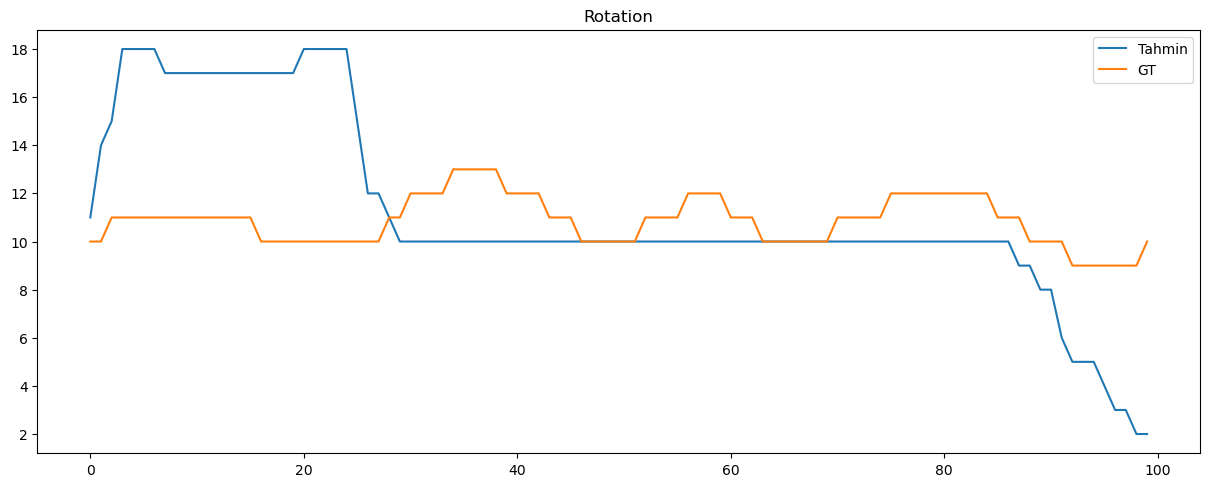

In [450]:
%matplotlib inline
plt.plot(np.argmax(prediction_train[1][30], axis=1),label="Tahmin")
plt.plot(np.argmax(tf.concat([i['rotation'] for i in y_train], axis=0)[30], axis=1), label="GT")

plt.title("Rotation")
#plt.xlim([0,50])

plt.legend()
plt.show()

In [451]:
%matplotlib qt
ax = plt.axes()

for i in range(prediction_train[0].shape[0]-1):
    ax.cla()
    ax.plot(np.argmax(prediction_train[1][i], axis=1),label="Tahmin")
    ax.plot(np.argmax(tf.concat([i['rotation'] for i in y_train], axis=0)[i], axis=1), label="GT")

    ax.set_title("Translation frame : " + str(i))
    #plt.xlim([0,50])

    ax.legend()
    plt.pause(0.0000000000001)
    plt.show()

In [452]:
X_test = list(map(lambda x: x[0], test_data))
y_test = list(map(lambda x: x[1], test_data))

In [453]:
predictions[0].shape

(6, 100, 21)

In [454]:
tf.concat([i['translation'] for i in y_test], axis=0)[0].shape

TensorShape([100, 21])

In [455]:
np.argmax(tf.concat([i['rotation'] for i in y_test], axis=0)[0], axis=1)

array([13, 13, 13, 12, 11, 11, 11, 11, 10,  9,  9,  8,  8,  7,  7,  7,  6,
        5,  5,  4,  4,  4,  3,  3,  3,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  3,  3,  4,  4,  5,  6,  7,  7,  8,  8,  9,  9, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
      dtype=int64)

In [456]:
np.argmax(predictions[0][0], axis=1)

array([19, 19, 19, 19, 19, 19, 19, 15, 15, 15, 15, 19, 19, 19, 19, 19, 19,
       19, 19, 19, 19, 19, 15, 15, 19, 19, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 14, 14, 14, 14, 15, 15, 14,
       12, 12, 12, 12, 12, 12, 12, 11, 11, 11, 11, 11, 11, 11, 11,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  7,  7,  7,  6,  6,  6,  6],
      dtype=int64)

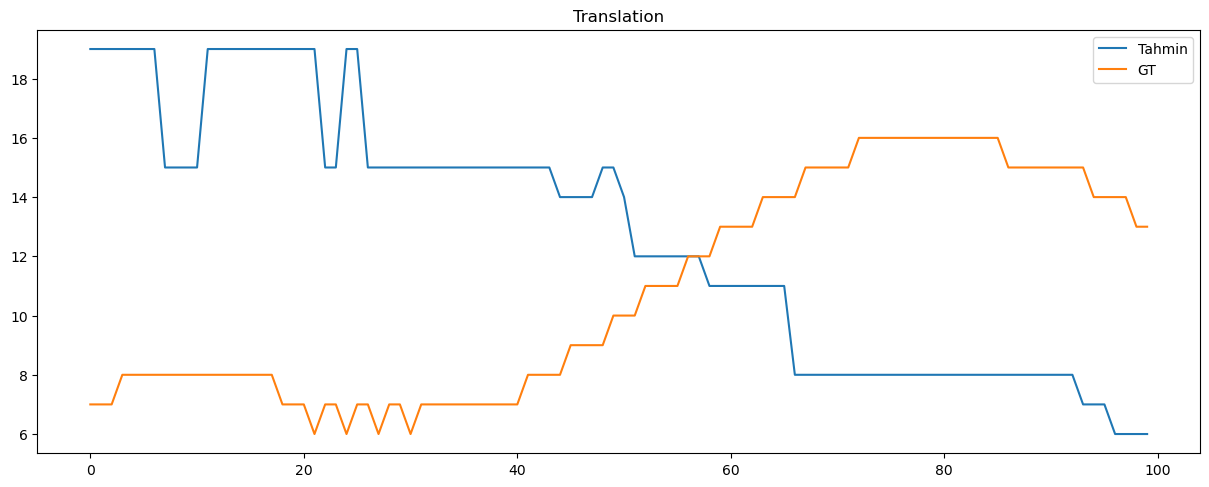

In [457]:
%matplotlib inline
plt.plot(np.argmax(predictions[0][0], axis=1),label="Tahmin")
plt.plot(np.argmax(tf.concat([i['translation'] for i in y_test], axis=0)[0], axis=1), label="GT")

plt.title("Translation")
#plt.xlim([0,50])

plt.legend()
plt.show()

In [458]:
%matplotlib qt
ax = plt.axes()

for i in range(predictions[0].shape[0]-1):
    ax.cla()
    ax.plot(np.argmax(predictions[0][i], axis=1),label="Tahmin")
    ax.plot(np.argmax(tf.concat([i['translation'] for i in y_test], axis=0)[i], axis=1), label="GT")

    ax.set_title("Translation frame : " + str(i))
    #plt.xlim([0,50])

    ax.legend()
    plt.pause(0.0000000000001)
    plt.show()

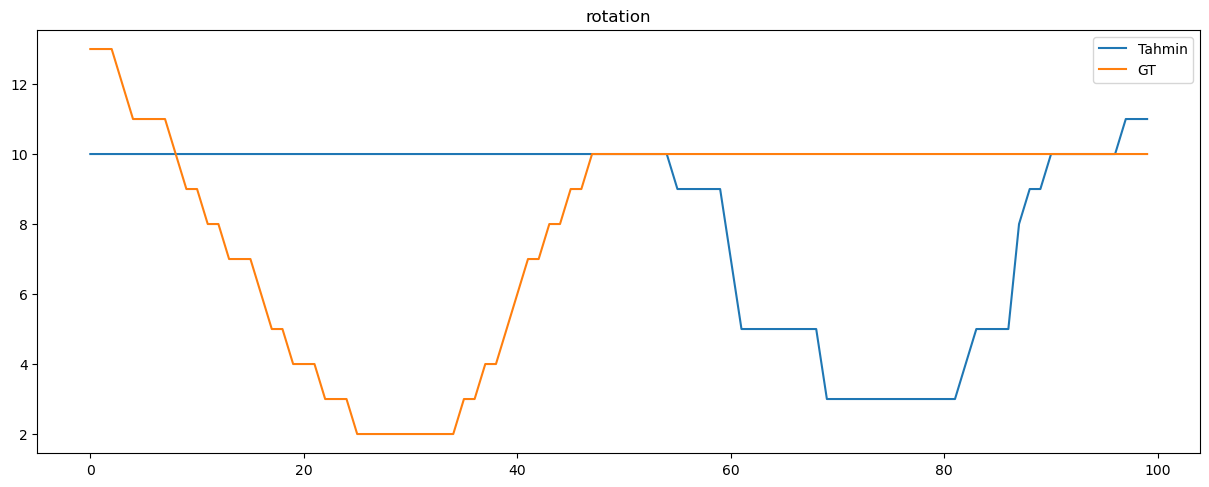

In [459]:
%matplotlib inline
plt.plot(np.argmax(predictions[1][0], axis=1),label="Tahmin")
plt.plot(np.argmax(tf.concat([i['rotation'] for i in y_test], axis=0)[0], axis=1), label="GT")
plt.legend()
#plt.xlim([0,10])
plt.title("rotation")
plt.show()

In [460]:
%matplotlib qt
ax = plt.axes()

for i in range(predictions[0].shape[0]-1):
    ax.cla()
    ax.plot(np.argmax(predictions[1][i], axis=1),label="Tahmin")
    ax.plot(np.argmax(tf.concat([i['rotation'] for i in y_test], axis=0)[i], axis=1), label="GT")

    ax.set_title("Translation frame : " + str(i))
    #plt.xlim([0,50])

    ax.legend()
    plt.pause(0.0000000000001)
    plt.show()

#  K-Fold CNN training

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pykitti
import math 
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import tensorflow as tf
def readBinDataset(filename):
    binDataset = np.load(filename, allow_pickle=True)
    #print(bin)

    return binDataset

In [52]:
total_dataset_sz = 11
binDataset_ = []

In [53]:
#windows
for sequence in range(total_dataset_sz):
    binDataset_.append(readBinDataset(r"D:\Ara\numpy_dataset_sequences\%02d_angleBin.npy" % sequence))
    binDataset_[sequence]=binDataset_[sequence].reshape((len(binDataset_[sequence]), 3601,1 ))
    binDataset_[sequence] = np.array([ consec_frames for consec_frames in zip(binDataset_[sequence][0::], binDataset_[sequence][1::])])

# linux
#binDataset=readBinDataset("/mnt/d/Ara/numpy_dataset_sequences/%02d_angleBin.npy" % sequence)

In [54]:
len(binDataset_),  binDataset_[0].shape

(11, (4540, 2, 3601, 1))

In [55]:
from IPython.display import clear_output

%matplotlib inline
label_ = []
for sequence in range(total_dataset_sz):
    
    basedir = 'D:\\dataset\\'
    sequence_ = '%02d' % sequence
    dataset = pykitti.odometry(basedir, sequence_)
    
   
    x=np.array([])
    y=np.array([])
    z=np.array([])
    yaw=np.array([])

    fig = plt.figure(sequence)
    ax = fig.add_subplot(projection='3d' )
    ax.set_title(str(sequence))
    for i in range(len(dataset.poses)):
        x=np.append(x, [dataset.poses[i][0][3]])
        y=np.append(y, [dataset.poses[i][1][3]])
        z=np.append(z, [dataset.poses[i][2][3]])

    ax.scatter(x, y, z, marker='o')
    
    ax.view_init(-140, 60)
    plt.pause(0.1)
    plt.clf()

    t_xyz = np.c_[x, y, z]
    dt_xyz = t_xyz[1:] - t_xyz[0:-1]
    dt_xz = dt_xyz[:,[0,2]]
    translation_ = np.sqrt( dt_xz[:,0]** 2 +  dt_xz[:,1]**2)

    translation_ += 0.28 
    
    
    fig1 = plt.figure()
    yaw_=np.zeros(len(dataset.poses))
    for i in range(len(dataset.poses)):
        r= R.from_matrix([[dataset.poses[i][0][0], dataset.poses[i][0][1], dataset.poses[i][0][2]], [dataset.poses[i][1][0], dataset.poses[i][1][1], dataset.poses[i][1][2]], [dataset.poses[i][2][0], dataset.poses[i][2][1], dataset.poses[i][2][2]]])
        yaw=-r.as_rotvec()[1]
        yaw_[i]=yaw
    # plt.plot(np.rad2deg(yaw_))

    diff_pitch_ = -(yaw_[1::]-yaw_[:-1:])

    # outlier detection
    idxs = np.where((diff_pitch_>np.deg2rad(300)) | (diff_pitch_<np.deg2rad(-300)))

    diff_pitch_[idxs] =  diff_pitch_[idxs] - np.deg2rad(360)  * np.sign(diff_pitch_[idxs])

    label_.append(np.transpose(np.array((translation_,diff_pitch_))))
    
    plt.plot((np.rad2deg(diff_pitch_)))
    plt.pause(0.001)
    plt.clf()
#     plt.ylim([-4, 4])
#     plt.show()

clear_output(wait=True)

<Figure size 640x480 with 0 Axes>

In [56]:
((len(label_)),binDataset_[0].shape, label_[0].shape)

(11, (4540, 2, 3601, 1), (4540, 2))

In [57]:
binDataset_ = np.array(binDataset_)
label_ = np.array(label_)
binDataset_.shape, label_.shape

C:\Users\filiz\AppData\Local\Temp\ipykernel_1296\785166724.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  binDataset_ = np.array(binDataset_)
C:\Users\filiz\AppData\Local\Temp\ipykernel_1296\785166724.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  label_ = np.array(label_)


((11,), (11,))

In [58]:
binDataset_ = np.concatenate(binDataset_)
label_ =  np.concatenate(label_)

In [59]:
binDataset_.shape, label_.shape

((23190, 2, 3601, 1), (23190, 2))

## Outlier analysis of CNN

In [60]:
def binOutput(label, sample_sz):
    t_bin = np.zeros(sample_sz)
    r_bin = np.zeros(sample_sz)

    interval = sample_sz-1

    t_bin = np.zeros(sample_sz)
    r_bin = np.zeros(sample_sz)
    labelBinned = np.array([[t_bin,r_bin]])
    for data in label:
        t_bin = np.zeros(sample_sz)
        r_bin = np.zeros(sample_sz)
        t_bin[int(((data[0]*interval)))] = 1
        r_bin[int(((data[1]*interval)))] = 1
        
        labelBinned = np.concatenate([labelBinned, np.array([np.array([t_bin, r_bin])])], axis=0)
    return labelBinned[1:]

In [61]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(label_)

label_ = scaler.transform(label_)
scaler.data_max_, scaler.data_min_

(array([3.01743329, 0.07704157]), array([ 0.28007151, -0.08327863]))

In [62]:
labelBinned = binOutput(label_, 21)

In [63]:
labelBinned.shape, label.shape

((23190, 2, 21), (22160, 2))

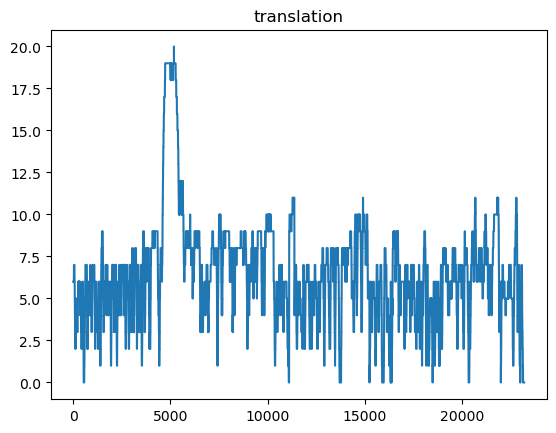

In [64]:
np.where(labelBinned[:,0] > 0)[1]
plt.title('translation')
plt.plot(np.where(labelBinned[:,0] > 0)[1])

(array([ 872., 2497., 4903., 7689., 5161., 1214.,   80.,   73.,  117.,
         584.]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.]),
 <BarContainer object of 10 artists>)

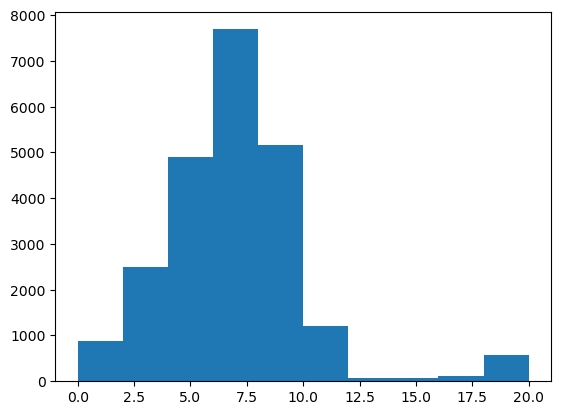

In [65]:
plt.hist(np.where(labelBinned[:,0] > 0)[1])

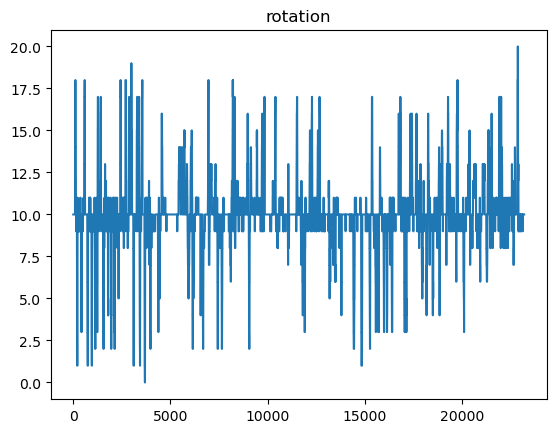

In [66]:
np.where(labelBinned[:,1] > 0)[1].shape
plt.title('rotation')
plt.plot(np.where(labelBinned[:,1] > 0)[1])

(array([   63.,   349.,   553.,   811.,  3400., 15197.,  1483.,   758.,
          484.,    92.]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.]),
 <BarContainer object of 10 artists>)

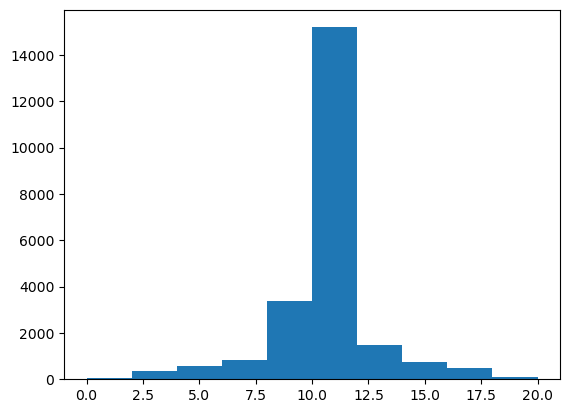

In [67]:
plt.hist(np.where(labelBinned[:,1] > 0)[1])

In [68]:
outliers = np.where(np.where(labelBinned[:,0] > 0)[1]>11)
outliers = outliers[0]

In [69]:
(outliers[-1] - outliers[0]) == (max(outliers) - min(outliers))

True

In [70]:
min_truncate = outliers[0]
max_truncate = outliers[-1]
min_truncate, max_truncate

(4607, 5639)

In [71]:
labelBinned=np.delete(labelBinned,np.s_[min_truncate:max_truncate],axis=0 )
binDataset=np.delete(binDataset_,np.s_[min_truncate:max_truncate],axis=0 )

## After Outlier Analysis

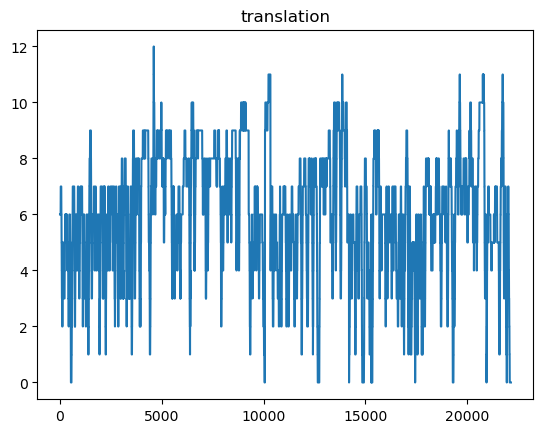

In [72]:
np.where(labelBinned[:,0] > 0)[1]
plt.title('translation')
plt.plot(np.where(labelBinned[:,0] > 0)[1])

(array([ 872.,  959., 1538., 2072., 2831., 7689., 2881., 2280.,  890.,
         146.]),
 array([ 0. ,  1.2,  2.4,  3.6,  4.8,  6. ,  7.2,  8.4,  9.6, 10.8, 12. ]),
 <BarContainer object of 10 artists>)

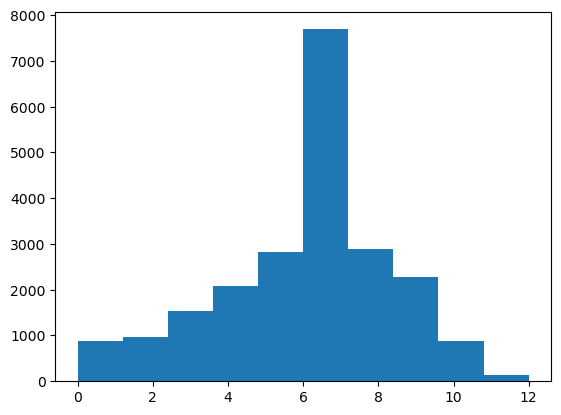

In [73]:
plt.hist(np.where(labelBinned[:,0] > 0)[1])

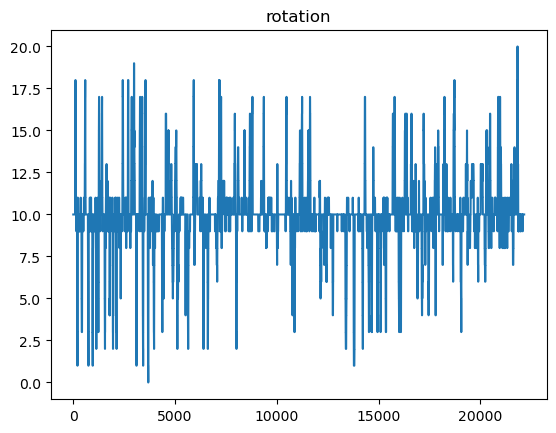

In [74]:
np.where(labelBinned[:,1] > 0)[1].shape
plt.title('rotation')
plt.plot(np.where(labelBinned[:,1] > 0)[1])

(array([   63.,   349.,   553.,   811.,  3395., 14337.,  1384.,   690.,
          484.,    92.]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.]),
 <BarContainer object of 10 artists>)

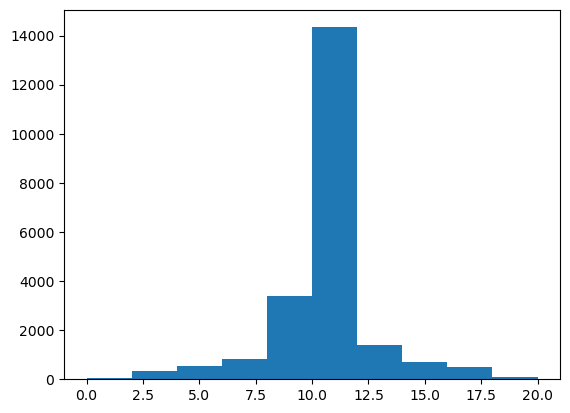

In [75]:
plt.hist(np.where(labelBinned[:,1] > 0)[1])

In [76]:
from sklearn.model_selection import KFold
num_folds = 5

In [77]:
# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

verbosity = 1
no_epochs = 30
batch_size = 32

In [78]:
from keras import backend as K
import keras

def reset_weights(model):
    for layer in model.layers: 
        if isinstance(layer, tf.keras.Model):
            reset_weights(layer)
            continue
        for k, initializer in layer.__dict__.items():
            if "initializer" not in k:
                continue
            # find the corresponding variable
            var = getattr(layer, k.replace("_initializer", ""))
            var.assign(initializer(var.shape, var.dtype))

In [79]:
reset_weights(model)
keras.backend.clear_session()

c:\Users\filiz\anaconda3\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [80]:
fold_no = 1

In [81]:
acc_per_fold = []

In [82]:
loss_per_fold = []

In [83]:
def plotAngleBin(ax,angleBin):
    
    ax.scatter(0,0)
    xList = []
    yList = []
    for angle, bin in enumerate(angleBin):
        if bin > 0:
            y=bin*np.sin(np.deg2rad(angle*0.1))
            x=bin*np.cos(np.deg2rad(angle*0.1))
            xList.append(x)
            yList.append(y)
            # ax.scatter(x,y)
    ax.scatter(xList,yList)
    plt.pause(0.00000000000001)
    plt.show()

# K-Fold Eğitim için gerekli kütüphanelerin getirilmesi

In [84]:
import tensorflow as tf

In [85]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import concatenate
from keras.layers import TimeDistributed
from keras.layers import LSTM
np.random.seed(16)
tf.random.set_seed(16)

In [86]:
input_layer = tf.keras.layers.Input(shape=(2,3601,1))

In [87]:
# model_ = Dense(1024, activation='relu')(model(input_layer))
# model2 = Dense(1024, activation='relu')(model(input_layer))



model1 = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-3))(model(input_layer))
model2 = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-3))(model(input_layer))

model1 = Dropout(0.2) (model1)
model2 = Dropout(0.2) (model2)

model1 = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-3))(model1)
model2 = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-3))(model2)

model1 = tf.keras.layers.Dropout(0.2) (model1)
model2 = tf.keras.layers.Dropout(0.2) (model2)

model1 = Dense(21, name="translation",activation='softmax')(model1) # translate
model2 = Dense(21, name="rotation",activation='softmax')(model2) # yaw

# model1 = tf.keras.layers.Activation('softmax', name="translation")(model1)
# model2 = tf.keras.layers.Activation('softmax', name="rotation")(model2)

kfold_cnn_model = tf.keras.Model(inputs=[input_layer], outputs=[model1, model2])

kfold_cnn_model.compile(loss = 'categorical_crossentropy',
              optimizer='adam',
              metrics = ['accuracy'])

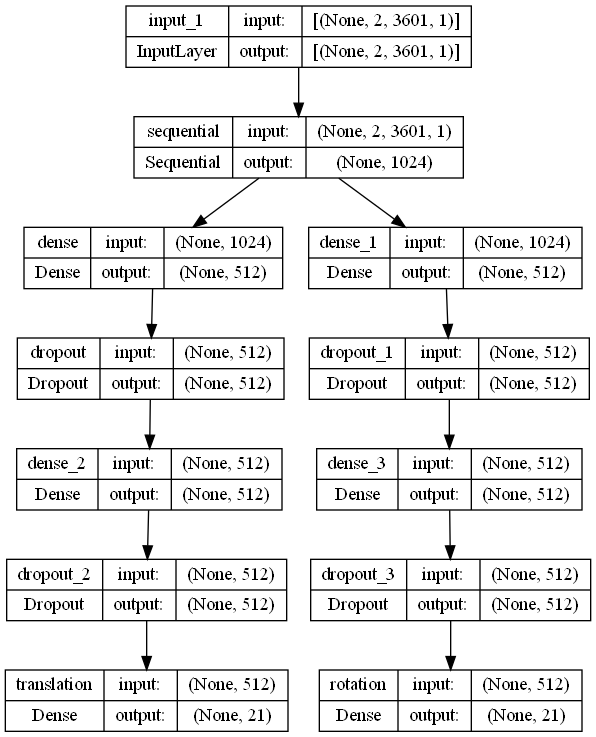

In [88]:
tf.keras.utils.plot_model(kfold_cnn_model, show_shapes=True)

In [89]:
def binOutput(label, sample_sz):
    t_bin = np.zeros(sample_sz)
    r_bin = np.zeros(sample_sz)

    interval = sample_sz-1

    t_bin = np.zeros(sample_sz)
    r_bin = np.zeros(sample_sz)
    labelBinned = np.array([[t_bin,r_bin]])
    for data in label:
        t_bin = np.zeros(sample_sz)
        r_bin = np.zeros(sample_sz)
        t_bin[int(((data[0]*interval)))] = 1
        r_bin[int(((data[1]*interval)))] = 1
        
        labelBinned = np.concatenate([labelBinned, np.array([np.array([t_bin, r_bin])])], axis=0)
    return labelBinned[1:]

In [90]:
binDataset.shape, labelBinned.shape

((22158, 2, 3601, 1), (22158, 2, 21))

In [91]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


binDataset_train, binDataset_test, label_train_t, label_test_t , label_train_r ,label_test_r = train_test_split(binDataset, labelBinned[:,0,:], labelBinned[:,1,:], test_size=0.33)

In [92]:
reset_weights(kfold_cnn_model)
keras.backend.clear_session()
for train, test in kfold.split(binDataset_train, label_train_t):
    train_data_ = binDataset_train[train]
    train_label_t = label_train_t[train]
    train_label_r = label_train_r[train]
    


    dataset_ = tf.data.Dataset.from_tensor_slices((train_data_, {"translation": train_label_t, "rotation" : train_label_r}))
    full_dataset_ = dataset_.shuffle(buffer_size=100).batch(batch_size=batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

    history=kfold_cnn_model.fit(full_dataset_,
              epochs=no_epochs,
              verbose=verbosity)
    

    test_data_ = binDataset_train[test]
    test_label_t = label_train_t[test]
    test_label_r = label_train_r[test]
    

    test_label_data = {"translation": test_label_t, "rotation" : test_label_r}

    # Generate generalization metrics
    scores = kfold_cnn_model.evaluate(test_data_, test_label_data, verbose=0)
    print(f'Score for fold {fold_no}: {kfold_cnn_model.metrics_names[-2]} of {scores[-2]}; {kfold_cnn_model.metrics_names[-1]} of {scores[-1]}')
   
    
    test_label_data = {"translation": label_test_t, "rotation" : label_test_r}

    # Generate generalization metrics
    scores = kfold_cnn_model.evaluate(binDataset_test, test_label_data, verbose=0)
    print(f'Score for fold {fold_no} Test data: translation acc of {scores[-2]}; rotation acc of {scores[-1]}')

    acc_per_fold.append(scores[-2])
    loss_per_fold.append(scores[-1])

    fold_no = fold_no + 1
    

Epoch 1/30
372/372 [==============================] - 36s 39ms/step - loss: 4.0668 - translation_loss: 2.0604 - rotation_loss: 1.4690 - translation_accuracy: 0.2094 - rotation_accuracy: 0.5802
Epoch 2/30
372/372 [==============================] - 14s 38ms/step - loss: 3.1832 - translation_loss: 1.7871 - rotation_loss: 1.1861 - translation_accuracy: 0.2900 - rotation_accuracy: 0.6189
Epoch 3/30
372/372 [==============================] - 14s 38ms/step - loss: 2.8561 - translation_loss: 1.6183 - rotation_loss: 1.0560 - translation_accuracy: 0.3463 - rotation_accuracy: 0.6453
Epoch 4/30
372/372 [==============================] - 14s 38ms/step - loss: 2.6207 - translation_loss: 1.4739 - rotation_loss: 0.9595 - translation_accuracy: 0.3978 - rotation_accuracy: 0.6668
Epoch 5/30
372/372 [==============================] - 14s 39ms/step - loss: 2.3941 - translation_loss: 1.3246 - rotation_loss: 0.8620 - translation_accuracy: 0.4510 - rotation_accuracy: 0.6902
Epoch 6/30
372/372 [===============

# Save Pretrained CNN Model

In [93]:
# serialize model to JSON
model_json = kfold_cnn_model.to_json()
with open("kfold_cnn_model2.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
kfold_cnn_model.save_weights("kfold_cnn_model2.h5")
print("Saved model to disk")

Saved model to disk


# Load PreTrained CNN Model

In [94]:
# load json and create model
json_file = open('kfold_cnn_model2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("kfold_cnn_model2.h5")
print("Loaded model from disk")

Loaded model from disk


In [95]:
loaded_model.compile(loss = 'categorical_crossentropy',
              optimizer='adam',
              metrics = ['accuracy'])

In [96]:
binDataset_test.shape ,label_test_t.shape , label_test_r.shape

((7313, 2, 3601, 1), (7313, 21), (7313, 21))

In [97]:
test_label_data = {"translation": label_test_t, "rotation" : label_test_r}

# Generate generalization metrics
scores = loaded_model.evaluate(binDataset_test, test_label_data, verbose=0)
scores

[2.429514169692993,
 1.1863961219787598,
 1.0462660789489746,
 0.7760153412818909,
 0.8084233403205872]

In [ ]:
def plotAngleBin(ax,angleBin):
    ax.cla()
    ax.scatter(0,0)
    xList = []
    yList = []
    for angle, bin in enumerate(angleBin):
        if bin > 0:
            y=bin*np.sin(np.deg2rad(angle*0.1))
            x=bin*np.cos(np.deg2rad(angle*0.1))
            xList.append(x)
            yList.append(y)
            # ax.scatter(x,y)
    ax.scatter(xList,yList)
    plt.pause(0.00000000000001)
    plt.show()

In [ ]:
train_batch = full_dataset_.as_numpy_iterator()
example_trained_data = train_batch.next()
example_trained_data[0].shape # input
print(example_trained_data[1]['translation'].shape, example_trained_data[1]['rotation'].shape)
example_bin_input = example_trained_data[0]
example_bin_output_translation= example_trained_data[1]['translation']
example_bin_output_rotation = example_trained_data[1]['rotation']


%matplotlib qt
# %matplotlib inline
fig, axs = plt.subplots(2)
axs[0].set_aspect('equal', adjustable='box')
axs[1].set_aspect('equal', adjustable='box')

for i in range(len(example_trained_data[0])):
    fig.suptitle("Batch verisi")
    text = fig.text(0.1, 0.1,"translation:{translation} rotation:{rotation} ".format(translation=np.argmax(example_bin_output_translation[i]), rotation=np.argmax(example_bin_output_rotation[i])))
    plotAngleBin(axs[0], example_bin_input[i][0])
    
    plotAngleBin(axs[1], example_bin_input[i][1])
    text.remove()
    
    # print(example_bin_input_time_distributed[i][0] == example_bin_input_time_distributed[i][1])


(32, 21) (32, 21)


# Tek tek değerlendir

In [ ]:
binDataset_test[train].shape, label_test_t[train].shape, label_test_r[train].shape

In [102]:
test_data_ = binDataset_test
test_label_t = label_test_t
test_label_r = label_test_r


test_label_data = {"translation": test_label_t, "rotation" : test_label_r}

# Generate generalization metrics
scores = kfold_cnn_model.evaluate(test_data_, test_label_data, verbose=0)
print(f'Score for fold {fold_no}: {kfold_cnn_model.metrics_names[-2]} of {scores[-2]}; {kfold_cnn_model.metrics_names[-1]} of {scores[-1]}')


Score for fold 11: translation_accuracy of 0.714344322681427; rotation_accuracy of 0.7656228542327881


In [157]:
X_test = list(map(lambda x: x[0], test_data_))
y_test = list(map(lambda x: x[1], test_label_data['translation'])) 

In [139]:
predictions = kfold_cnn_model.predict(test_data_)

88/88 [==============================] - 3s 14ms/step


In [164]:
predictions[0].shape, test_label_data['translation'].shape

((2790, 21), (2790, 21))

In [175]:
fig, axs = plt.subplots(2)
axs[0].set_aspect('equal', adjustable='box')
axs[1].set_aspect('equal', adjustable='box')
  
for i in range(len(test_label_data['translation'])):
    axs[0].cla()
    axs[1].cla()

    axs[0].plot(predictions[0][i],label="Tahmin")
    axs[1].plot(test_label_data['translation'][i], label="GT")
    
    plt.title("Translation")
    plt.legend()
    plt.pause(0.0000000001)
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

KeyboardInterrupt: 

In [82]:
plt.plot(predictions[1], label="Tahmin")
plt.plot(tf.concat(y_test,0)[:,1], label="GT")
plt.legend()
#plt.xlim([0,10])
plt.title("rotation")
plt.show()

NameError: name 'predictions' is not defined

# GAZEBODAN ELDE EDILEN VERI ILE EĞITME

## Gazebodan çekilen verisetinin kontrol edilmesi

In [93]:
dataset2read = 2

In [94]:
binDataset_gazebo=readBinDataset(rf"D:\Ara\numpy_dataset_sequences_gazebo\{dataset2read}_angleBin.npy")

In [95]:
binDataset_gazebo_laser = binDataset_gazebo.item().get('lidarDataset')
binDataset_gazebo_label = binDataset_gazebo.item().get('labelDataset')

In [96]:
infinite_mask = np.array([np.inf]*3601)

In [97]:
is_corrupted_sequence = np.all(binDataset_gazebo_laser[0] == infinite_mask)
if is_corrupted_sequence is not True:
    dataset2read += 1
    binDataset_gazebo=readBinDataset(rf"D:\Ara\numpy_dataset_sequences_gazebo\{dataset2read}_angleBin.npy")
    binDataset_gazebo_laser = binDataset_gazebo.item().get('lidarDataset')
    binDataset_gazebo_label = binDataset_gazebo.item().get('labelDataset')

In [99]:
binDataset_gazebo_laser.shape, binDataset_gazebo_label.shape

((478, 3601), (478, 2))

In [100]:
is_corrupted_sequence = np.all(binDataset_gazebo_laser[0] == infinite_mask)
is_corrupted_sequence

False

In [102]:
def plotAngleBin(ax,angleBin):
    ax.cla()
    ax.scatter(0,0)
    xList = []
    yList = []
    for angle, bin in enumerate(angleBin):
        if bin > 0:
            y=bin*np.sin(np.deg2rad(angle*0.1))
            x=bin*np.cos(np.deg2rad(angle*0.1))
            xList.append(x)
            yList.append(y)
            # ax.scatter(x,y)
    ax.scatter(xList,yList)
    plt.pause(0.00000000000001)
    plt.show()

In [103]:
%matplotlib qt
# %matplotlib inline
fig, axs = plt.subplots(2)
axs[0].set_aspect('equal', adjustable='box')
axs[1].set_aspect('equal', adjustable='box')

for i in range(len(binDataset_gazebo_laser)-1):
    fig.suptitle("Örnek Sequence Verisi")
    text = fig.text(0.05, 0.05,"translation:{translation} rotation:{rotation} ".format(translation=binDataset_gazebo_label[i][0], rotation=binDataset_gazebo_label[i][1]))
    plotAngleBin(axs[0], binDataset_gazebo_laser[i])
    
    plotAngleBin(axs[1], binDataset_gazebo_laser[i+1])
    text.remove()
    
    # print(example_bin_input_time_distributed[i][0] == example_bin_input_time_distributed[i][1])


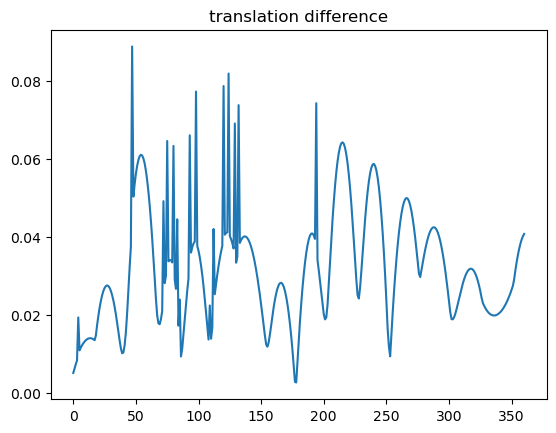

In [57]:
%matplotlib inline
plt.title("translation difference")
plt.plot(binDataset_gazebo_label[:,0])

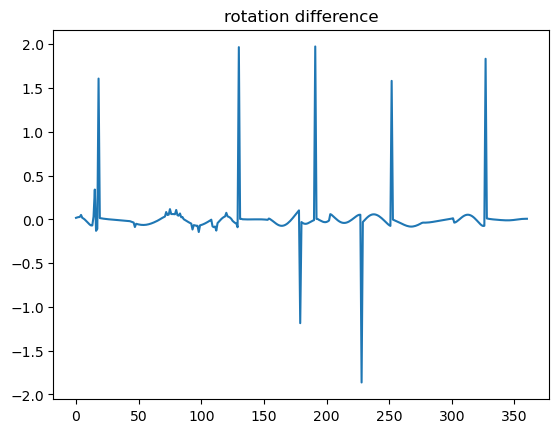

In [58]:
%matplotlib inline
plt.title("rotation difference")
plt.plot(binDataset_gazebo_label[:,1])

(array([  1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   6.,
         10.,  45.,  60.,  95., 106.,  67.,  46.,  33.,  10.,   3.,   1.,
          1.]),
 array([-1.7491972 , -1.73015434, -1.71111149, -1.69206863, -1.67302577,
        -1.65398292, -1.63494006, -1.61589721, -1.59685435, -1.5778115 ,
        -1.55876864, -1.53972578, -1.52068293, -1.50164007, -1.48259722,
        -1.46355436, -1.44451151, -1.42546865, -1.40642579, -1.38738294,
        -1.36834008, -1.34

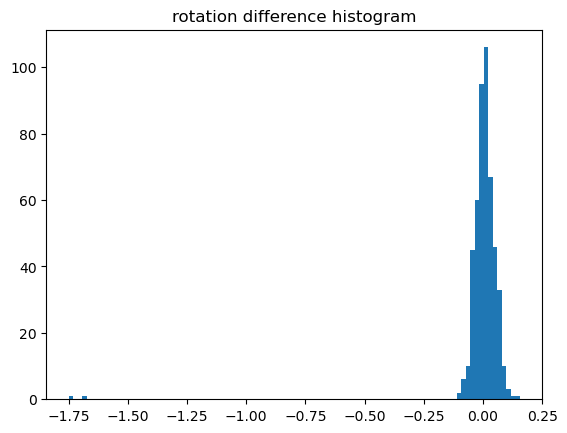

In [50]:
%matplotlib inline
plt.title("rotation difference histogram")
plt.hist(binDataset_gazebo_label[:,1], bins=100)

(array([ 4.,  2.,  7., 11., 15., 24., 21., 35., 44., 35., 23., 28., 40.,
        17., 15., 15., 14., 21., 17., 19., 14., 10., 10., 10., 13., 10.,
         1.,  4.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,
         0.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  1.]),
 array([0.00142759, 0.00382386, 0.00622012, 0.00861639, 0.01101265,
        0.01340892, 0.01580518, 0.01820145, 0.02059771, 0.02299398,
        0.02539024, 0.02778651, 0.03018277, 0.03257904, 0.0349753 ,
        0.03737157, 0.03976783, 0.0421641 , 0.04456036, 0.04695663,
        0.04935289, 0.05174916, 0.05414542, 0.05654169, 0.05893796,
        0.06133422, 0.06373049, 0.06612675, 0.06852302, 0.07091928,
        0.07331555, 0.07571181, 0.07810808, 0.08050434, 0.08290061,
        0.08529687, 0.08769314, 0.0900894 , 0.09248567, 0.09488193,
        0.0972782 , 0.09967446, 0.10207073, 0.10446699, 0.10686326,
        0.10925952, 0.11165579, 0.11405205, 0.11644832, 0.11884458,
        0.12124085]),
 <BarContainer

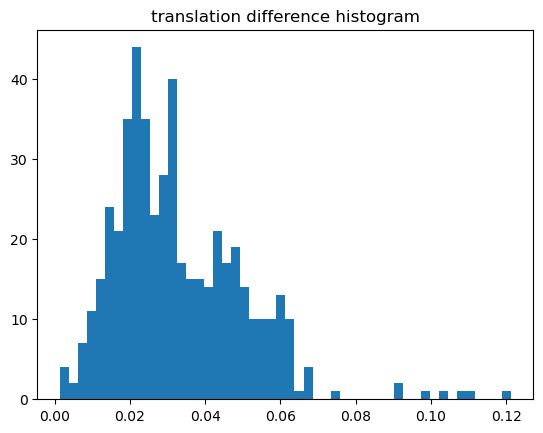

In [52]:
%matplotlib inline
plt.title("translation difference histogram")
plt.hist(binDataset_gazebo_label[:,0], bins=50)

In [38]:
binDataset_gazebo_label[i][0]

0.03473066617833077

In [39]:
#windows
for sequence in range(total_dataset_sz):
    binDataset_.append(readBinDataset(r"D:\Ara\numpy_dataset_sequences\%02d_angleBin.npy" % sequence))
    binDataset_[sequence]=binDataset_[sequence].reshape((len(binDataset_[sequence]), 3601,1 ))
    binDataset_[sequence] = np.array([ consec_frames for consec_frames in zip(binDataset_[sequence][0::], binDataset_[sequence][1::])])

# linux
#binDataset=readBinDataset("/mnt/d/Ara/numpy_dataset_sequences/%02d_angleBin.npy" % sequence)

NameError: name 'total_dataset_sz' is not defined

# Odometri Sonucunu Çizdir

# Modeli Ubuntuya Göndermek İçin Kaydet

# Laser verisini gazebodan al

# Laser verisini kutula ve modele değerlendirme olarak at

# Çıkan sonuçtan artımlı odometri çiz

# Deterministik Modeli Kur ve Karşılaştır